In [1]:
import os

In [2]:
!pwd

/content


In [3]:
!apt install openjdk-8-jdk-headless -qq

The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package libxtst6:amd64.
(Reading database ... 121666 files and directories currently installed.)
Preparing to unpack .../libxtst6_2%3a1.2.3-1build4_amd64.deb ...
Unpacking libxtst6:amd64 (2:1.2.3-1build4) ...
Selecting previously unselected package openjdk-8-jre-headless:amd64.
Preparing to unpack .../openjdk-8-jre-headless_8u392-ga-1~22.04_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u392-ga-1~22.04) ...
Selec

In [4]:
os.environ["JAVA_HOME"]="/usr/lib/jvm/java-8-openjdk-amd64"

In [5]:
!echo $JAVA_HOME

/usr/lib/jvm/java-8-openjdk-amd64


In [6]:
!pip install pyspark==3.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=add50979a8094a6003c6c5d6d978022d73f7c57e6dfc7ad095217360c89ae15a
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [7]:
!pip install dash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 51.7 MB/s eta 0:00:00


In [106]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.functions import col, sum, when, isnan, lit
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.types import *

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import psutil
import time
import plotly.express as px
from dash import Dash, html, dcc, callback, Output, Input

In [22]:
psutil.cpu_percent()

9.3

In [17]:
psutil.virtual_memory().percent

7.4

In [23]:
spark = SparkSession.builder.master("local[*]").appName('ml-app').config('spark.ui.port', '4050').getOrCreate()

In [24]:
spark

In [25]:
!pip install pyngrok

In [26]:
!ngrok config add-authtoken 2ZaBUAZRFrUDE2oh9u3c9MFNxna_3rmZi4Q76e5z5xhhdTH4G

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [130]:
df = spark.read.csv('/content/train_full.csv',inferSchema=True,header=True)
df_test = spark.read.csv('/content/test_full.csv',inferSchema=True,header=True)

In [42]:
print((df_test.count(),len(df_test.columns)))

(3747, 19)


In [43]:
print((df.count(),len(df.columns)))

(7559, 19)


In [44]:
df_test.printSchema()

root
 |-- PassengerId: string (nullable = true)
 |-- HomePlanet: string (nullable = true)
 |-- CryoSleep: boolean (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Destination: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- VIP: boolean (nullable = true)
 |-- RoomService: double (nullable = true)
 |-- FoodCourt: double (nullable = true)
 |-- ShoppingMall: double (nullable = true)
 |-- Spa: double (nullable = true)
 |-- VRDeck: double (nullable = true)
 |-- Name: string (nullable = true)
 |-- Transported: boolean (nullable = true)
 |-- Group: double (nullable = true)
 |-- Lastname: string (nullable = true)
 |-- Deck: string (nullable = true)
 |-- Cab_num: double (nullable = true)
 |-- Deck_side: string (nullable = true)



In [48]:
df.printSchema()

root
 |-- PassengerId: string (nullable = true)
 |-- HomePlanet: string (nullable = true)
 |-- CryoSleep: boolean (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Destination: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- VIP: boolean (nullable = true)
 |-- RoomService: double (nullable = true)
 |-- FoodCourt: double (nullable = true)
 |-- ShoppingMall: double (nullable = true)
 |-- Spa: double (nullable = true)
 |-- VRDeck: double (nullable = true)
 |-- Name: string (nullable = true)
 |-- Transported: boolean (nullable = true)
 |-- Group: double (nullable = true)
 |-- Lastname: string (nullable = true)
 |-- Deck: string (nullable = true)
 |-- Cab_num: double (nullable = true)
 |-- Deck_side: string (nullable = true)



In [49]:
df.show(5)

+-----------+----------+---------+-----+-----------+----+-----+-----------+---------+------------+------+------+-----------------+-----------+-----+-----------+----+-------+---------+
|PassengerId|HomePlanet|CryoSleep|Cabin|Destination| Age|  VIP|RoomService|FoodCourt|ShoppingMall|   Spa|VRDeck|             Name|Transported|Group|   Lastname|Deck|Cab_num|Deck_side|
+-----------+----------+---------+-----+-----------+----+-----+-----------+---------+------------+------+------+-----------------+-----------+-----+-----------+----+-------+---------+
|    0001_01|    Europa|    false|B/0/P|TRAPPIST-1e|39.0|false|        0.0|      0.0|         0.0|   0.0|   0.0|  Maham Ofracculy|      false|  1.0|  Ofracculy|   B|    0.0|        P|
|    0002_01|     Earth|    false|F/0/S|TRAPPIST-1e|24.0|false|      109.0|      9.0|        25.0| 549.0|  44.0|     Juanna Vines|       true|  2.0|      Vines|   F|    0.0|        S|
|    0003_01|    Europa|    false|A/0/S|TRAPPIST-1e|58.0| true|       43.0|   35

In [50]:
df.dtypes

[('PassengerId', 'string'),
 ('HomePlanet', 'string'),
 ('CryoSleep', 'boolean'),
 ('Cabin', 'string'),
 ('Destination', 'string'),
 ('Age', 'double'),
 ('VIP', 'boolean'),
 ('RoomService', 'double'),
 ('FoodCourt', 'double'),
 ('ShoppingMall', 'double'),
 ('Spa', 'double'),
 ('VRDeck', 'double'),
 ('Name', 'string'),
 ('Transported', 'boolean'),
 ('Group', 'double'),
 ('Lastname', 'string'),
 ('Deck', 'string'),
 ('Cab_num', 'double'),
 ('Deck_side', 'string')]

In [131]:
df = df.union(df_test)

In [53]:
print((df.count(),len(df.columns)))

(11306, 19)


In [132]:
df = df.withColumn("index", monotonically_increasing_id())

In [133]:
passenger_id_df = df.select(["PassengerId", "index"])

In [56]:
passenger_id_df.show(5)

+-----------+-----+
|PassengerId|index|
+-----------+-----+
|    0001_01|    0|
|    0002_01|    1|
|    0003_01|    2|
|    0003_02|    3|
|    0004_01|    4|
+-----------+-----+
only showing top 5 rows



In [134]:
my_data = df.drop(*['PassengerId', 'Name'])

In [58]:
my_data.columns

['HomePlanet',
 'CryoSleep',
 'Destination',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Transported',
 'Group',
 'Lastname',
 'Deck',
 'Cab_num',
 'Deck_side',
 'index']

In [59]:
(my_data.count() , len(my_data.columns))

(11306, 17)

In [60]:
my_data.describe().show()

+-------+----------+-----------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+-----+-----------------+---------+--------------------+
|summary|HomePlanet|Destination|               Age|      RoomService|         FoodCourt|      ShoppingMall|               Spa|            VRDeck|             Group|  Lastname| Deck|          Cab_num|Deck_side|               index|
+-------+----------+-----------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+-----+-----------------+---------+--------------------+
|  count|     11306|      11306|             11306|            11306|             11306|             11306|             11306|             11306|             11306|     11306|11306|            11306|    11306|               11306|
|   mean|      NULL|       NULL|28.746003530566533|222.3643561248657| 456.64

In [135]:
data_agg = my_data.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in my_data.columns])
data_agg.show()

+----------+---------+-----+-----------+---+---+-----------+---------+------------+---+------+-----------+-----+--------+----+-------+---------+-----+
|HomePlanet|CryoSleep|Cabin|Destination|Age|VIP|RoomService|FoodCourt|ShoppingMall|Spa|VRDeck|Transported|Group|Lastname|Deck|Cab_num|Deck_side|index|
+----------+---------+-----+-----------+---+---+-----------+---------+------------+---+------+-----------+-----+--------+----+-------+---------+-----+
|         0|        0|    0|          0|  0|  0|          0|        0|           0|  0|     0|          0|    0|       0|   0|      0|        0|    0|
+----------+---------+-----+-----------+---+---+-----------+---------+------------+---+------+-----------+-----+--------+----+-------+---------+-----+



In [62]:
my_data.dtypes

[('HomePlanet', 'string'),
 ('CryoSleep', 'boolean'),
 ('Destination', 'string'),
 ('Age', 'double'),
 ('VIP', 'boolean'),
 ('RoomService', 'double'),
 ('FoodCourt', 'double'),
 ('ShoppingMall', 'double'),
 ('Spa', 'double'),
 ('VRDeck', 'double'),
 ('Transported', 'boolean'),
 ('Group', 'double'),
 ('Lastname', 'string'),
 ('Deck', 'string'),
 ('Cab_num', 'double'),
 ('Deck_side', 'string'),
 ('index', 'bigint')]

In [136]:
my_data.groupBy('HomePlanet').count().show()
print()
my_data.groupBy('Destination').count().show()
print()
my_data.groupBy('Lastname').count().show()
print()
my_data.groupBy('Deck').count().show()
print()
my_data.groupBy('Deck_side').count().show()


+----------+-----+
|HomePlanet|count|
+----------+-----+
|      Mars| 2396|
|     Earth| 6125|
|    Europa| 2785|
+----------+-----+


+-------------+-----+
|  Destination|count|
+-------------+-----+
|PSO J318.5-22| 1056|
|  TRAPPIST-1e| 7900|
|  55 Cancri e| 2350|
+-------------+-----+


+----------+-----+
|  Lastname|count|
+----------+-----+
|  Brighttt|    8|
|   Klinson|    4|
|       Kin|    4|
|Gilleranks|    8|
|   Baldens|    3|
|    Modent|    2|
| Loverthyo|    4|
|    Ticiay|    1|
|     Monie|    2|
| Kerrealds|    8|
|   Chardst|    4|
|Rinicapead|    4|
|      Oncy|    2|
|     Midtt|    6|
| Pinoffent|    6|
|    Ingent|    8|
|     Peate|    1|
|      Cort|    6|
|      Stik|    2|
|  Diazarez|    2|
+----------+-----+
only showing top 20 rows


+----+-----+
|Deck|count|
+----+-----+
|   F| 3771|
|   E| 1178|
|   T|    7|
|   B| 1026|
|   D|  649|
|   C|  987|
|   A|  314|
|   G| 3374|
+----+-----+


+---------+-----+
|Deck_side|count|
+---------+-----+
|        S| 56

In [170]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import monotonically_increasing_id

In [137]:
bool_data = my_data.select([col(c).cast("integer") for c in ["CryoSleep", "VIP", "Transported"]])
bool_data = bool_data.withColumn("index", monotonically_increasing_id())

In [138]:
bool_data = bool_data.withColumnRenamed("CryoSleep", "CryoSleep_value")
bool_data = bool_data.withColumnRenamed("VIP", "VIP_value")
bool_data = bool_data.withColumnRenamed("Transported", "Transported_value")

In [139]:
bool_data.show(10)

+---------------+---------+-----------------+-----+
|CryoSleep_value|VIP_value|Transported_value|index|
+---------------+---------+-----------------+-----+
|              0|        0|                0|    0|
|              0|        0|                1|    1|
|              0|        1|                0|    2|
|              0|        0|                0|    3|
|              0|        0|                1|    4|
|              0|        0|                1|    5|
|              0|        0|                1|    6|
|              1|        0|                1|    7|
|              0|        0|                1|    8|
|              1|        0|                1|    9|
+---------------+---------+-----------------+-----+
only showing top 10 rows



In [225]:
combined_data = my_data.join(bool_data, on="index", how="inner")

In [226]:
combined_data.show(5)

+-----+----------+---------+-----+-----------+----+-----+-----------+---------+------------+------+------+-----------+-----+-----------+----+-------+---------+---------------+---------+-----------------+
|index|HomePlanet|CryoSleep|Cabin|Destination| Age|  VIP|RoomService|FoodCourt|ShoppingMall|   Spa|VRDeck|Transported|Group|   Lastname|Deck|Cab_num|Deck_side|CryoSleep_value|VIP_value|Transported_value|
+-----+----------+---------+-----+-----------+----+-----+-----------+---------+------------+------+------+-----------+-----+-----------+----+-------+---------+---------------+---------+-----------------+
|    0|    Europa|    false|B/0/P|TRAPPIST-1e|39.0|false|        0.0|      0.0|         0.0|   0.0|   0.0|      false|  1.0|  Ofracculy|   B|    0.0|        P|              0|        0|                0|
|    1|     Earth|    false|F/0/S|TRAPPIST-1e|24.0|false|      109.0|      9.0|        25.0| 549.0|  44.0|       true|  2.0|      Vines|   F|    0.0|        S|              0|        0

In [227]:
SI_HomePlanet = StringIndexer(inputCol='HomePlanet',outputCol='HomePlanet_Index')
SI_Destination = StringIndexer(inputCol='Destination',outputCol='Destination_Index')
SI_Lastname = StringIndexer(inputCol='Lastname',outputCol='Lastname_Index')
SI_Deck = StringIndexer(inputCol='Deck',outputCol='Deck_Index')
SI_Deck_side = StringIndexer(inputCol='Deck_side',outputCol='DeckSide_Index')
ST_VRDeck = StringIndexer(inputCol="VRDeck", outputCol="VRDeck_index")
ST_ShoppingMall = StringIndexer(inputCol="ShoppingMall", outputCol="ShoppingMall_index")
ST_RoomService = StringIndexer(inputCol="RoomService", outputCol="RoomService_index")
ST_Age = StringIndexer(inputCol="Age", outputCol="Age_index")
ST_FoodCourt = StringIndexer(inputCol="FoodCourt", outputCol="FoodCourt_index")
ST_Spa = StringIndexer(inputCol="Spa", outputCol="Spa_index")

In [228]:
combined_data = SI_HomePlanet.fit(combined_data).transform(combined_data)
combined_data = SI_Destination.fit(combined_data).transform(combined_data)
combined_data = SI_Lastname.fit(combined_data).transform(combined_data)
combined_data = SI_Deck.fit(combined_data).transform(combined_data)
combined_data = SI_Deck_side.fit(combined_data).transform(combined_data)
combined_data = ST_VRDeck.fit(combined_data).transform(combined_data)
combined_data= ST_ShoppingMall.fit(combined_data).transform(combined_data)
combined_data= ST_RoomService.fit(combined_data).transform(combined_data)
combined_data= ST_Age.fit(combined_data).transform(combined_data)
combined_data= ST_FoodCourt.fit(combined_data).transform(combined_data)
combined_data= ST_Spa.fit(combined_data).transform(combined_data)

In [229]:
combined_data.select('HomePlanet', 'HomePlanet_Index', 'Destination', 'Destination_Index','Lastname','Lastname_Index','Deck','Deck_Index','Deck_side','DeckSide_Index').show(10)

+----------+----------------+-------------+-----------------+-----------+--------------+----+----------+---------+--------------+
|HomePlanet|HomePlanet_Index|  Destination|Destination_Index|   Lastname|Lastname_Index|Deck|Deck_Index|Deck_side|DeckSide_Index|
+----------+----------------+-------------+-----------------+-----------+--------------+----+----------+---------+--------------+
|    Europa|             1.0|  TRAPPIST-1e|              0.0|  Ofracculy|        1638.0|   B|       3.0|        P|           1.0|
|     Earth|             0.0|  TRAPPIST-1e|              0.0|      Vines|        1757.0|   F|       0.0|        S|           0.0|
|    Europa|             1.0|  TRAPPIST-1e|              0.0|     Susent|         563.0|   A|       6.0|        S|           0.0|
|    Europa|             1.0|  TRAPPIST-1e|              0.0|     Susent|         563.0|   A|       6.0|        S|           0.0|
|     Earth|             0.0|  TRAPPIST-1e|              0.0|Santantines|         246.0|  

In [230]:
combined_data.show(5)

+-----+----------+---------+-----+-----------+----+-----+-----------+---------+------------+------+------+-----------+-----+-----------+----+-------+---------+---------------+---------+-----------------+----------------+-----------------+--------------+----------+--------------+------------+------------------+-----------------+---------+---------------+---------+
|index|HomePlanet|CryoSleep|Cabin|Destination| Age|  VIP|RoomService|FoodCourt|ShoppingMall|   Spa|VRDeck|Transported|Group|   Lastname|Deck|Cab_num|Deck_side|CryoSleep_value|VIP_value|Transported_value|HomePlanet_Index|Destination_Index|Lastname_Index|Deck_Index|DeckSide_Index|VRDeck_index|ShoppingMall_index|RoomService_index|Age_index|FoodCourt_index|Spa_index|
+-----+----------+---------+-----+-----------+----+-----+-----------+---------+------------+------+------+-----------+-----+-----------+----+-------+---------+---------------+---------+-----------------+----------------+-----------------+--------------+----------+----

In [231]:
pandas_df = combined_data.toPandas()

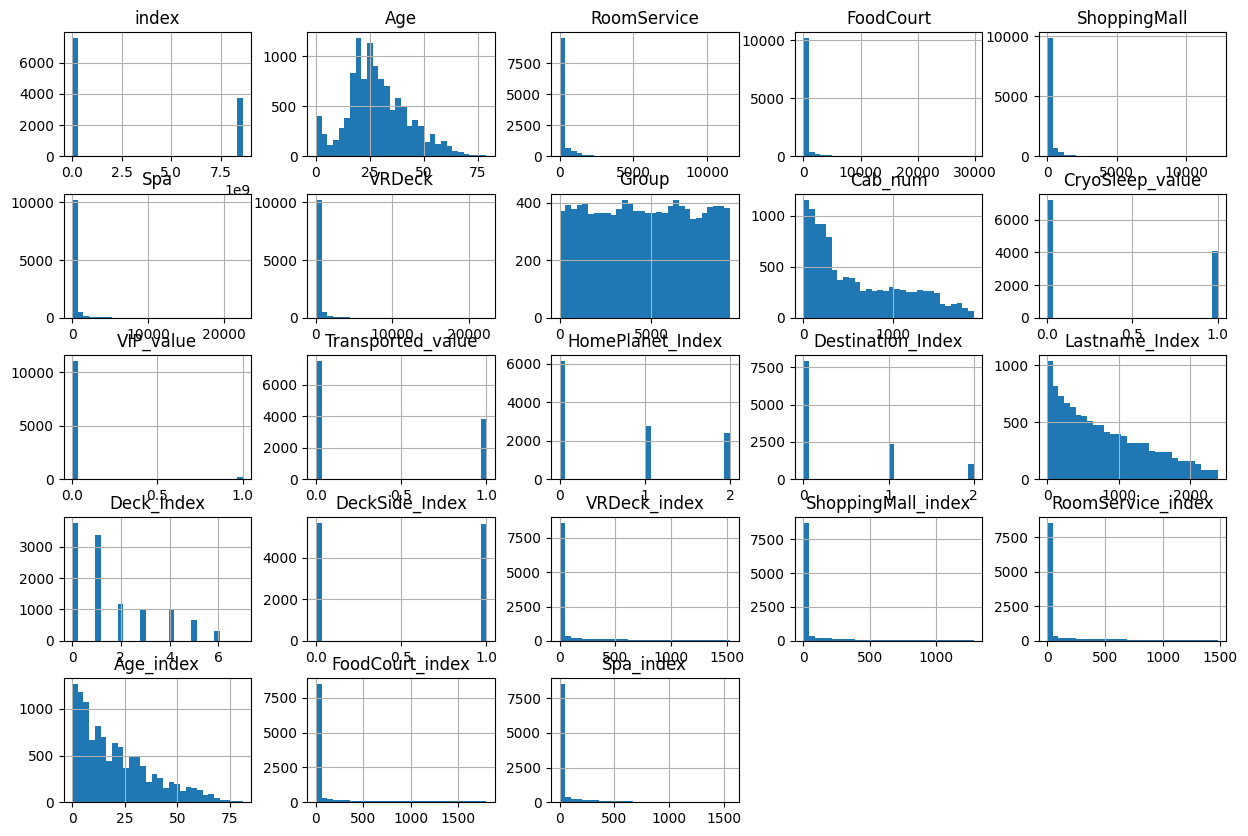

In [120]:
pandas_df.hist(bins=30, figsize=(15, 10))
plt.show()

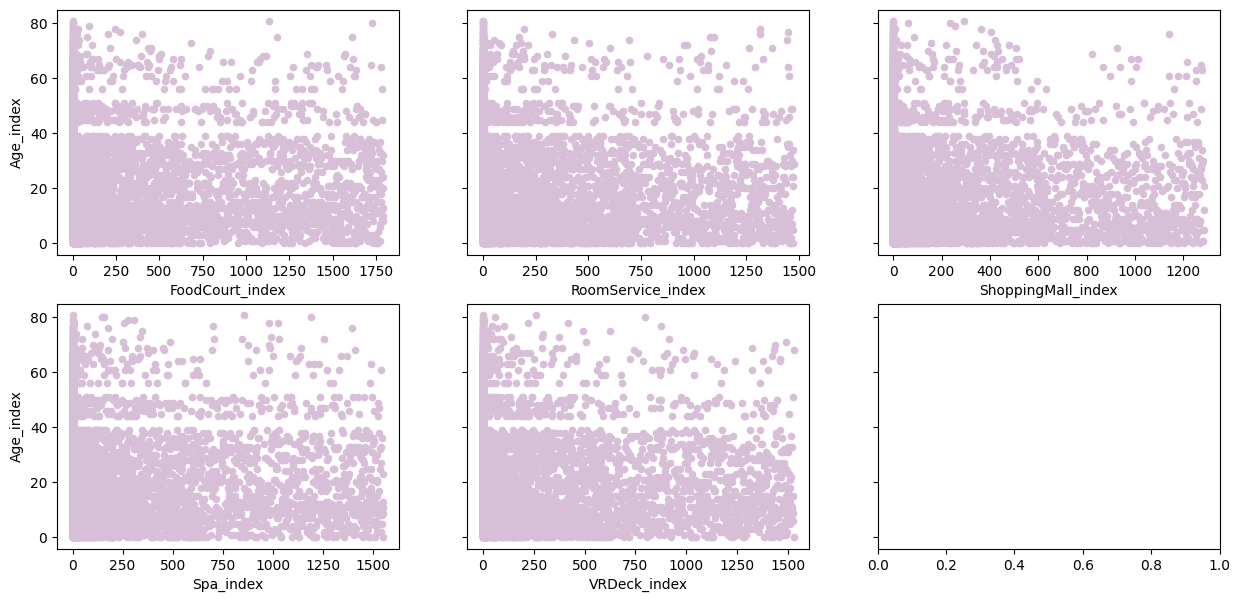

In [121]:
fig, axes = plt.subplots(2, 3, sharey=True, figsize=(15, 7))
pandas_df.plot.scatter(x='FoodCourt_index', y='Age_index', ax=axes[0, 0], color='thistle')
pandas_df.plot.scatter(x='RoomService_index', y='Age_index', ax=axes[0, 1] , color='thistle')
pandas_df.plot.scatter(x='ShoppingMall_index', y='Age_index', ax=axes[0, 2], color='thistle')
pandas_df.plot.scatter(x='Spa_index', y='Age_index', ax=axes[1, 0], color='thistle')
pandas_df.plot.scatter(x='VRDeck_index', y='Age_index', ax=axes[1, 1], color='thistle')
plt.show()

In [232]:
combined_data = combined_data.withColumn(
    "RoomService_index",
    when(combined_data.RoomService_index > 9000, 9000).otherwise(combined_data.RoomService_index)
)
combined_data = combined_data.withColumn(
    "FoodCourt_index",
    when(combined_data.FoodCourt_index > 22000, 22000).otherwise(combined_data.RoomService_index)
)
combined_data = combined_data.withColumn(
    "ShoppingMall_index",
    when(combined_data.ShoppingMall_index > 11000, 11000).otherwise(combined_data.RoomService_index)
)
combined_data = combined_data.withColumn(
    "Spa_index",
    when(combined_data.Spa_index > 17000, 17000).otherwise(combined_data.RoomService_index)
)
combined_data = combined_data.withColumn(
    "VRDeck_index",
    when(combined_data.VRDeck_index > 21000, 21000).otherwise(combined_data.RoomService_index)
)

In [233]:
services = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [234]:
result = combined_data.filter(col("CryoSleep") == True).select([sum(col(service)).alias(service) for service in services])

In [235]:
result.show()

+-----------------+-----------------+------------------+------------------+-----------------+
|      RoomService|        FoodCourt|      ShoppingMall|               Spa|           VRDeck|
+-----------------+-----------------+------------------+------------------+-----------------+
|18080.42735749347|44240.81417889904|19738.386794482543|28955.937049718385|25449.32866971832|
+-----------------+-----------------+------------------+------------------+-----------------+



In [236]:
pandas_df['Total_expenses'] = pandas_df[services].sum(axis=1)

In [237]:
Group_members = pandas_df.Group.value_counts().to_dict()
pandas_df['Group_members'] = pandas_df.Group.map(Group_members)

In [238]:
Cabin_members = pandas_df.Cabin.value_counts().to_dict()
pandas_df['Cabin_members'] = pandas_df.Cabin.map(Cabin_members)

In [239]:
pandas_df.Cabin_members.fillna(pandas_df.Cabin_members.mean(), inplace=True)

In [240]:
col_drop = ['Cabin', 'Lastname']
pandas_df = pandas_df.drop(col_drop, axis=1)

In [241]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11306 entries, 0 to 11305
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               11306 non-null  int64  
 1   HomePlanet          11306 non-null  object 
 2   CryoSleep           11306 non-null  bool   
 3   Destination         11306 non-null  object 
 4   Age                 11306 non-null  float64
 5   VIP                 11306 non-null  bool   
 6   RoomService         11306 non-null  float64
 7   FoodCourt           11306 non-null  float64
 8   ShoppingMall        11306 non-null  float64
 9   Spa                 11306 non-null  float64
 10  VRDeck              11306 non-null  float64
 11  Transported         11306 non-null  bool   
 12  Group               11306 non-null  float64
 13  Deck                11306 non-null  object 
 14  Cab_num             11306 non-null  float64
 15  Deck_side           11306 non-null  object 
 16  Cryo

In [168]:
def transported_chance_by(feature, xticks=None, xlim=None):
    transported = pandas_df[pandas_df.Transported == 1]
    not_transported = pandas_df[pandas_df.Transported == 0]

    plt.figure(figsize=(10, 5))

    transported[feature].plot(kind='kde', label='transported')
    not_transported[feature].plot(kind='kde', label='not_transported')

    plt.xlim(xlim)
    plt.xticks(xticks)
    plt.legend()
    plt.grid()
    plt.xlabel(feature)
    plt.show()

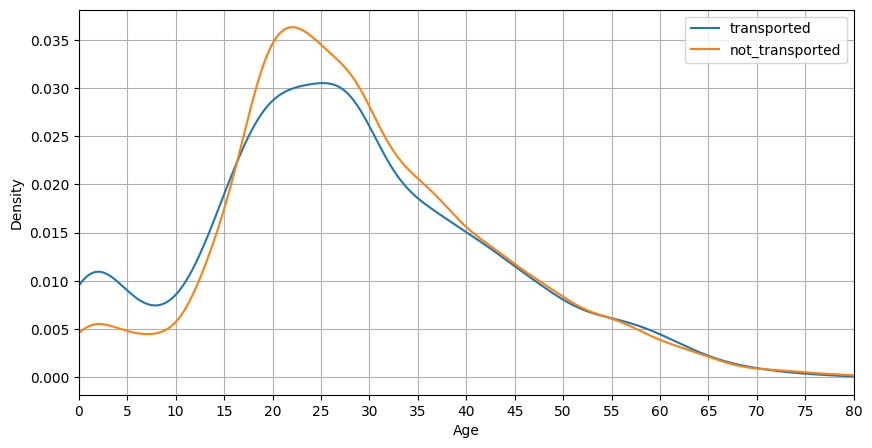

In [169]:
transported_chance_by('Age', np.arange(0, 81, 5), (0, 80))

In [242]:
spark_df = spark.createDataFrame(pandas_df)

In [243]:
OHE = OneHotEncoder(inputCols=['Age_index', 'RoomService_index','FoodCourt_index','ShoppingMall_index','Spa_index','VRDeck_index','Group', "Cab_num", "HomePlanet_Index", "Destination_Index" , "Lastname_Index", "Deck_Index", "DeckSide_Index", "CryoSleep_value", "VIP_value"],
                    outputCols=['Age_index_OHE', 'RoomService_index_OHE','FoodCourt_index_OHE','ShoppingMall_index_OHE','Spa_index_OHE','VRDeck_index_OHE','Group_OHE', "Cab_num_OHE", "HomePlanet_Index_OHE", "Destination_Index_OHE" , "Lastname_Index_OHE", "Deck_Index_OHE",
                                "DeckSide_Index_OHE", "CryoSleep_value_OHE", "VIP_value_OHE"])

In [244]:
combined_OHE_data = OHE.fit(spark_df).transform(spark_df)

In [218]:
combined_OHE_data.select('Age', 'Age_index', 'Age_index_OHE').show(10)

+----+---------+---------------+
| Age|Age_index|  Age_index_OHE|
+----+---------+---------------+
|39.0|     27.0|(81,[27],[1.0])|
|24.0|      1.0| (81,[1],[1.0])|
|58.0|     51.0|(81,[51],[1.0])|
|33.0|     15.0|(81,[15],[1.0])|
|16.0|     25.0|(81,[25],[1.0])|
|44.0|     33.0|(81,[33],[1.0])|
|26.0|      7.0| (81,[7],[1.0])|
|28.0|     10.0|(81,[10],[1.0])|
|35.0|     14.0|(81,[14],[1.0])|
|14.0|     26.0|(81,[26],[1.0])|
+----+---------+---------------+
only showing top 10 rows



In [165]:
from pyspark.ml.feature import VectorAssembler

In [219]:
combined_OHE_data.printSchema()

root
 |-- index: long (nullable = true)
 |-- HomePlanet: string (nullable = true)
 |-- CryoSleep: boolean (nullable = true)
 |-- Destination: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- VIP: boolean (nullable = true)
 |-- RoomService: double (nullable = true)
 |-- FoodCourt: double (nullable = true)
 |-- ShoppingMall: double (nullable = true)
 |-- Spa: double (nullable = true)
 |-- VRDeck: double (nullable = true)
 |-- Transported: boolean (nullable = true)
 |-- Group: double (nullable = true)
 |-- Deck: string (nullable = true)
 |-- Cab_num: double (nullable = true)
 |-- Deck_side: string (nullable = true)
 |-- CryoSleep_value: long (nullable = true)
 |-- VIP_value: long (nullable = true)
 |-- Transported_value: long (nullable = true)
 |-- HomePlanet_Index: double (nullable = true)
 |-- Destination_Index: double (nullable = true)
 |-- Deck_Index: double (nullable = true)
 |-- DeckSide_Index: double (nullable = true)
 |-- VRDeck_index: double (nullable = true)
 |--

In [220]:
combined_OHE_data.show(5)

+-----+----------+---------+-----------+----+-----+-----------+---------+------------+------+------+-----------+-----+----+-------+---------+---------------+---------+-----------------+----------------+-----------------+----------+--------------+------------+------------------+-----------------+---------+---------------+---------+--------------+-------------+-------------+---------------+---------------------+-------------------+----------------------+-------------------+------------------+----------------+----------------+--------------------+---------------------+--------------+------------------+-------------------+-------------+
|index|HomePlanet|CryoSleep|Destination| Age|  VIP|RoomService|FoodCourt|ShoppingMall|   Spa|VRDeck|Transported|Group|Deck|Cab_num|Deck_side|CryoSleep_value|VIP_value|Transported_value|HomePlanet_Index|Destination_Index|Deck_Index|DeckSide_Index|VRDeck_index|ShoppingMall_index|RoomService_index|Age_index|FoodCourt_index|Spa_index|Total_expenses|Group_member

In [245]:
# specify the input and output columns of the vector assembler
assembler = VectorAssembler(inputCols=[
 'Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Group',
 'Cab_num',
 'HomePlanet_Index',
 'Destination_Index',
 'Lastname_Index',
 'Deck_Index',
 'DeckSide_Index',
 'CryoSleep_value',
 'VIP_value',
 'HomePlanet_Index_OHE',
 'Destination_Index_OHE',
 'Lastname_Index_OHE',
 'Deck_Index_OHE',
 'DeckSide_Index_OHE',
 'CryoSleep_value_OHE',
 'VIP_value_OHE'],
                           outputCol='features')


In [246]:
assembler.getInputCols()

['Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Group',
 'Cab_num',
 'HomePlanet_Index',
 'Destination_Index',
 'Lastname_Index',
 'Deck_Index',
 'DeckSide_Index',
 'CryoSleep_value',
 'VIP_value',
 'HomePlanet_Index_OHE',
 'Destination_Index_OHE',
 'Lastname_Index_OHE',
 'Deck_Index_OHE',
 'DeckSide_Index_OHE',
 'CryoSleep_value_OHE',
 'VIP_value_OHE']

In [247]:
data = combined_OHE_data.fillna(0)

In [248]:
data = assembler.transform(data)

In [208]:
data.show(5)

+-----+---------+----+-----------+---------+------------+------+------+-----------+----+---------+---------------+---------+-----------------+----------------+-----------------+----------+--------------+------------+------------------+-----------------+---------+---------------+---------+--------------+-------------+-------------+---------------+---------------------+-------------------+----------------------+-------------------+------------------+----------------+----------------+--------------------+---------------------+--------------+------------------+-------------------+-------------+--------------------+
|index|CryoSleep| Age|RoomService|FoodCourt|ShoppingMall|   Spa|VRDeck|Transported|Deck|Deck_side|CryoSleep_value|VIP_value|Transported_value|HomePlanet_Index|Destination_Index|Deck_Index|DeckSide_Index|VRDeck_index|ShoppingMall_index|RoomService_index|Age_index|FoodCourt_index|Spa_index|Total_expenses|Group_members|Cabin_members|  Age_index_OHE|RoomService_index_OHE|FoodCourt_i

In [209]:
data.select("Transported_value", "features").show(5)

+-----------------+--------------------+
|Transported_value|            features|
+-----------------+--------------------+
|                0|(26,[0,6,8,9,13,1...|
|                1|(26,[0,1,2,3,4,5,...|
|                0|(26,[0,1,2,4,5,6,...|
|                0|(26,[0,2,3,4,5,6,...|
|                1|(26,[0,1,2,3,4,5,...|
+-----------------+--------------------+
only showing top 5 rows



In [249]:
#Model_Dataframe
model_df = data.select(["features", "Transported_value"])
model_df = model_df.withColumnRenamed("Transported_value","label")
model_df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: long (nullable = true)



In [250]:
#Split into training & testing Dataframe
training_df,test_df = model_df.randomSplit([0.75,0.25])

In [190]:
from pyspark.ml.classification import LogisticRegression

In [251]:
log_reg = LogisticRegression(featuresCol="features", labelCol="label")

In [252]:
log_reg_model = log_reg.fit(training_df)

In [253]:
lr_summary=log_reg_model.summary

In [254]:
lr_summary.accuracy

0.8409573213864655

In [255]:
lr_summary.areaUnderROC

0.9215768111102991

In [256]:
print(lr_summary.precisionByLabel)

[0.8626083999319843, 0.7920030757401]


In [257]:
predictions = log_reg_model.transform(test_df)

In [258]:
predictions.select('label','prediction').show(20)

+-----+----------+
|label|prediction|
+-----+----------+
|    0|       0.0|
|    0|       0.0|
|    1|       1.0|
|    0|       0.0|
|    0|       1.0|
|    1|       0.0|
|    0|       0.0|
|    0|       1.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    1|       0.0|
|    0|       1.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       1.0|
+-----+----------+
only showing top 20 rows



In [259]:
training_df.explain(mode="formatted")

== Physical Plan ==
* Sample (5)
+- * Sort (4)
   +- * Project (3)
      +- * Project (2)
         +- * Scan ExistingRDD (1)


(1) Scan ExistingRDD [codegen id : 1]
Output [33]: [index#11824L, HomePlanet#11825, CryoSleep#11826, Destination#11827, Age#11828, VIP#11829, RoomService#11830, FoodCourt#11831, ShoppingMall#11832, Spa#11833, VRDeck#11834, Transported#11835, Group#11836, Deck#11837, Cab_num#11838, Deck_side#11839, CryoSleep_value#11840L, VIP_value#11841L, Transported_value#11842L, HomePlanet_Index#11843, Destination_Index#11844, Lastname_Index#11845, Deck_Index#11846, DeckSide_Index#11847, VRDeck_index#11848, ShoppingMall_index#11849, RoomService_index#11850, Age_index#11851, FoodCourt_index#11852, Spa_index#11853, Total_expenses#11854, Group_members#11855L, Cabin_members#11856L]
Arguments: [index#11824L, HomePlanet#11825, CryoSleep#11826, Destination#11827, Age#11828, VIP#11829, RoomService#11830, FoodCourt#11831, ShoppingMall#11832, Spa#11833, VRDeck#11834, Transported#11835,